In [3]:
import time
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy.matlib as npm
from scipy import signal
import pandas as pd
import mpl_interactions.ipyplot as iplt


In [4]:
class radar1:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 2.64*(10**9)
        self.L = 6272
        self.PRI = 2*(10**-6)
        self.PTM_len = 100
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.noise = 0
        self.Lambda = self.c/self.fc
        self.windowsum = 0
        self.ptx = 0
        self.gt = 0
        self.gr = 0
        self.ptx_linear = 10**(self.ptx//10) # This is supposed to be 1 now this 1000 dont know how this works
        self.gt_linear = 10**(self.gt//10)
        self.gr_linear = 10**(self.gr//10)
        self.radar_coeff = (np.sqrt(self.ptx_linear * self.gt_linear * self.gr_linear) * self.Lambda) / (4 * np.pi)

In [5]:
class radar2:
    def __init__(self):
        self.fc = 60*(10**9)
        self.fs = 1.76*(10**9)
        self.L = 512
        self.PRI = 2*(10**-6)
        self.c = 3*(10**8)
        self.ts = 1/self.fs
        self.noise = 1
        self.PTM_len = 100
        self.Lambda = self.c/self.fc
        self.dfd = 121
        self.im_fdmax = 12*(10**3)
        self.im_fdmin = -12*(10**3)
        self.snr = 45 # Variable SNR
        self.snr_linear = 10**(self.snr/10)

In [6]:
class target:
    def __init__(self, range_t, doppler_velocity, rcs_amp):
        self.range = range_t
        self.doppler_velocity = doppler_velocity
        self.rcs_amp = rcs_amp
        self.n_bodypart = 1

In [7]:
class antenna:
    def __init__(self, Lambda, Nelements, DOA):
        self.d_m = Lambda * 0.5
        self.Nelements = Nelements
        self.spacing = np.arange(0, (self.Nelements) * self.d_m, self.d_m)
        self.DOA = DOA # Angle for azimuth

In [76]:
def get_received_signal(target, radar1, xmat1, fs, fc, antenna, n_frame, radar2):
    print("Generating RX Signal + Noise")
    Lvec = radar1.ts * (np.arange(0,radar1.L))
    Mvec = radar1.PRI * np.arange(0,radar1.PTM_len)
    Larray = np.transpose(npm.repmat(Lvec, radar1.PTM_len, 1))
    Marray = npm.repmat(Mvec, radar1.L, 1)
    time_array = Larray + Marray
    
    # with open('time_array_py.npy', 'wb') as f:
    #     np.save(f, time_array)

    w = np.hamming(radar1.PTM_len)
    wmat = npm.repmat(np.transpose(w), radar1.L, 1)
    window_sum = np.sum(w)

    # Channel Modelling
    radar1.ptx = 30
    radar1.gt = 0
    radar1.gr = 0

    rxmat = np.zeros((2*radar1.L-1, radar1.PTM_len))
    rxmat_temp = np.zeros((2*radar1.L-1, radar1.PTM_len))
    range_to_delay_symbols = np.floor(((2*target.range)/radar1.c)/radar1.ts)
    delay_zero = np.zeros((int(range_to_delay_symbols) - 1, int(radar1.PTM_len)))
    suffix_zero = np.zeros((int(radar1.L - range_to_delay_symbols), int(radar1.PTM_len)))

    for nb in range(0,target.n_bodypart):
        velvec = target.doppler_velocity
        Doppler_ele = 2*np.pi*2*velvec/radar1.Lambda
        Doppler_Delay = np.exp(1j*(Doppler_ele*time_array))


        temp = np.multiply(np.multiply(wmat,xmat1),Doppler_Delay)
        amp = (target.rcs_amp/(target.range ** 2))
        rxmat_temp = (amp * 100) * np.concatenate((delay_zero, temp, suffix_zero), dtype = np.complex64)
        rxmat = rxmat + rxmat_temp
    # print(target.n_bodypart)
    rxmat = rxmat/target.n_bodypart
    rxmat = rxmat * radar1.radar_coeff

    # with open('rxmat_py.npy', 'wb') as f:
    #     np.save(f, rxmat)
    
    x_pos = np.argwhere(rxmat != 0)[0][0]
    x_conv = x_pos//1.5
    rxmat_final = rxmat[x_pos:x_pos + radar1.L][:]


    coeff_rx = np.divide(rxmat_final[0:4992][:], xmat1[0:4992][:])
    

    upsamp = np.zeros((2 * len(np.transpose(coeff_rx)[0]), radar1.PTM_len), dtype = np.complex64)
    for i in range(0, radar1.PTM_len):
        np.transpose(upsamp)[i] = signal.resample(np.transpose(coeff_rx)[i], len(upsamp))
    
    downsamp = signal.decimate(upsamp, 3, axis=0)
    
    received_coeff_golay = downsamp[2688:3200][:]

    # with open('received_coeff_golay_py.npy', 'wb') as f:
    #     np.save(f, received_coeff_golay)
    # with open('received_coeff_golay_py.npy', 'wb') as f:
    #     np.save(f, received_coeff_golay)
    
    tx = sio.loadmat("./data/tx_freq_domain.mat")["xmat"]
    xmat = np.transpose(np.transpose(tx)[:100])
    receieved_sg = np.multiply(received_coeff_golay, xmat)

    # with open('receieved_sg_py.npy', 'wb') as f:
    #     np.save(f, receieved_sg)
    rx_mat = np.zeros((1024,100), dtype = np.complex64)
    rx_mat[int(x_conv): int(x_conv) + 512][:] = receieved_sg
    
    print(radar1.Lambda)
    print()
    antenna_matrix = np.exp(1j * 2 * np.pi * (1/radar1.Lambda) * (np.sin(antenna.DOA * 2 * np.pi / 360)) * antenna.spacing)

    # with open('antenna_matrix_py.npy', 'wb') as f:
    #     np.save(f, antenna_matrix)
    
    # srx_volts = np.zeros((radar1.PTM_len, len(np.transpose(rx_mat)[0]), antenna.Nelements), dtype = np.complex64)
    # srx_volts = np.zeros((len(np.transpose(rx_mat)[0]), antenna.Nelements, radar1.PTM_len), dtype = np.complex64)

    # for i in range(0, radar1.PTM_len):
    #     np.transpose(srx_volts)[i] = np.transpose(np.transpose(rx_mat)[i].reshape(len(np.transpose(rx_mat)[i]), 1) * antenna_matrix.reshape(1, len(antenna_matrix)))
    # srx_volts = np.transpose(srx_volts.flatten())

    # K = 1.38 * 10**-23
    # F = 1.76
    # Ts = 290 * F
    # BW = 2.64 * 10**9

    # noise_power = K * Ts * BW
    # noise = np.sqrt(noise_power) * (np.random.randn(len(srx_volts)) + 1j * np.random.randn(len(srx_volts)))
    # srx_noise = srx_volts + noise
    # srx_noise = srx_noise.reshape(2 * radar2.L, radar2.PTM_len, antenna.Nelements)
    
    # return srx_noise 

In [77]:
# Load XMAT
xmat1 = sio.loadmat("./data/jrc_tx.mat")["xmat1"]
n_frame = 1

rxmat_t1 = get_received_signal(t1, 
                            radar1_in, 
                            xmat1, 
                            radar1_in.fs, 
                            radar1_in.fc, 
                            antenna_param, 
                            n_frame, 
                            radar2_in)

Generating RX Signal + Noise
0.005

[0.     0.0025 0.005  0.0075 0.01   0.0125 0.015  0.0175 0.02   0.0225
 0.025  0.0275 0.03   0.0325 0.035  0.0375 0.04   0.0425 0.045  0.0475
 0.05   0.0525 0.055  0.0575 0.06   0.0625 0.065  0.0675 0.07   0.0725
 0.075  0.0775]


In [55]:
radar1_in = radar1()
radar2_in = radar2()
doppler_axis = np.arange(radar2_in.im_fdmin, radar2_in.im_fdmax + radar2_in.dfd, radar2_in.dfd)
velocity_axis = doppler_axis * radar2_in.Lambda/2
delay_axis = np.arange(-radar2_in.L + 1, radar2_in.L)
range_axis = ((radar2_in.c * radar2_in.ts) / 2) * delay_axis

In [10]:
# Target 1
range_t = 15
velocity = 4
rcs_amp = 1
t1 = target(range_t, velocity, rcs_amp)

Nu_elements = 32 # Variable Number of Antenna
DOA_angle = 45 # Angle of Target
antenna_param = antenna(radar2_in.Lambda, Nu_elements, DOA_angle)

In [11]:
total_srx_noise = np.transpose(rxmat_t1, (1, 2, 0))

In [12]:
# Generate Transmitted Wave
tx = sio.loadmat("./data/tx_freq_domain.mat")["xmat"]
xmat = np.transpose(np.transpose(tx)[:100])
xmat_padded1 = np.zeros((1024, 100))
xmat_padded1[:radar2_in.L] = xmat
xmat_padded = np.zeros((1024, 100, antenna_param.Nelements), dtype=np.complex64)

for i in range(antenna_param.Nelements):
    np.transpose(xmat_padded)[0] = np.transpose(xmat_padded1 * np.exp(1j * 2 * np.pi * (1/radar1_in.Lambda) * np.sin(30 * 2 * np.pi / 360) * 0))
xmat_padded = np.transpose(xmat_padded, (1, 2, 0))

In [13]:
theta = np.arange(-90, 91, 1)
xmat_fft_conj_tran = np.zeros(shape=np.shape(total_srx_noise), dtype=np.csingle)
rxmat_fft = np.zeros(shape=np.shape(total_srx_noise), dtype=np.csingle)

In [41]:
for i in range(radar1_in.PTM_len):
    rxmat_fft[i] = np.fft.fft(total_srx_noise[i])
    xmat_fft_conj_tran[i] = np.conj(np.fft.fft(xmat_padded[i]))

y = np.zeros(shape=(radar1_in.PTM_len, len(theta), 2 * radar2_in.L), dtype=np.csingle)

for i in range(radar1_in.PTM_len):
    print("iteration:", i)
    for k in range(len(theta)):
        # print("\t\t\tangle:", theta[k])
        theta_k = (2*np.pi*np.sin(np.pi*theta[k]/180))/radar1_in.Lambda
        doppler_delay = np.diag(np.exp(-1j*theta_k*antenna_param.spacing))
        y[i][k][:] = np.fft.ifftshift(np.fft.ifft(np.diag(
            np.dot(np.dot(np.transpose(rxmat_fft[i]), doppler_delay), xmat_fft_conj_tran[i]) 
        )))
with open("y_result.npy", "wb") as f:
    np.save(f, y)


iteration: 0
iteration: 1
iteration: 2
iteration: 3
iteration: 4
iteration: 5
iteration: 6
iteration: 7
iteration: 8
iteration: 9
iteration: 10
iteration: 11
iteration: 12
iteration: 13
iteration: 14
iteration: 15
iteration: 16
iteration: 17
iteration: 18
iteration: 19
iteration: 20
iteration: 21
iteration: 22
iteration: 23
iteration: 24
iteration: 25
iteration: 26
iteration: 27
iteration: 28
iteration: 29
iteration: 30
iteration: 31
iteration: 32
iteration: 33
iteration: 34
iteration: 35
iteration: 36
iteration: 37
iteration: 38
iteration: 39
iteration: 40
iteration: 41
iteration: 42
iteration: 43
iteration: 44
iteration: 45
iteration: 46
iteration: 47
iteration: 48
iteration: 49
iteration: 50
iteration: 51
iteration: 52
iteration: 53
iteration: 54
iteration: 55
iteration: 56
iteration: 57
iteration: 58
iteration: 59
iteration: 60
iteration: 61
iteration: 62
iteration: 63
iteration: 64
iteration: 65
iteration: 66
iteration: 67
iteration: 68
iteration: 69
iteration: 70
iteration: 71
it

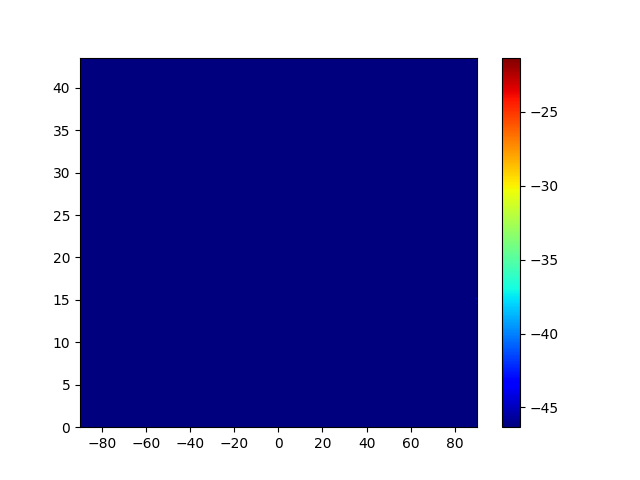

In [14]:
%matplotlib widget

y_res = np.load('./y_result.npy')
y_antenna = np.transpose(y_res[0])
win_hamm_col = np.hamming(181)
awin_col = np.sum(win_hamm_col)
power_music = 10*np.log10(np.abs(y_antenna[511:])/awin_col)

index_max = np.unravel_index(np.argmax(power_music, axis=None), power_music.shape)
power_music[index_max] = power_music[index_max] + 5
max_power = power_music[index_max]
fig, ax = plt.subplots(1,1)
plot_ra = ax.imshow(np.flip(power_music), cmap="jet", aspect="auto", 
                    vmin=max_power-20, vmax=max_power+5, 
                    extent=[theta[0], theta[::-1][0], range_axis[511:][0], range_axis[511:][::-1][0]])
fig.colorbar(plot_ra)
plt.show()